In [1]:
import mphot
import numpy as np
import matplotlib.pyplot as plt

In [2]:
instrument_efficiency_path = "../resources/systems/speculoos_Andor_iKon-L-936_-60.csv"  # index in microns, efficiency of telescope+instrument as fraction
filter_path = (
    "../resources/filters/I+z.csv"  # index in microns, filter efficiency as fraction
)

name, system_response = mphot.generate_system_response(
    instrument_efficiency_path, filter_path
)

INFO:mphot.core:`/Users/peter/Github/mphot/src/mphot/datafiles/system_responses/speculoos_Andor_iKon-L-936_-60_I+z_instrument_system_response.csv` has been generated and saved!


<Axes: title={'center': 'speculoos_Andor_iKon-L-936_-60_I+z'}, xlabel='Wavelength (microns)', ylabel='System Response'>

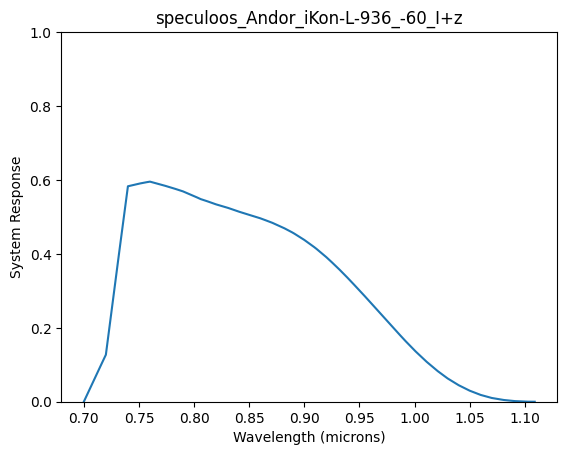

In [3]:
system_response.plot(
    xlabel="Wavelength (microns)", ylabel="System Response", title=name, ylim=(0, 1)
)

In [4]:
# sky properties
props_sky = {
    "pwv": 2.5,  # PWV [mm]
    "airmass": 1.1,  # airmass
    "seeing": 1.35,  # seeing (==FWHM) ["]
}

# instrument properties
props_instrument = {
    "name": name,  # name to get SR/precision grid from file
    "plate_scale": 0.35,  # pixel plate scale ["]
    "N_dc": 0.2,  # dark current [e/pix/s]
    "N_rn": 6.328,  # read noise [e_rms/pix]
    "well_depth": 64000,  # well depth [e/pix]
    "well_fill": 0.7,  # fractional value to fill central target pixel, assuming gaussian (width function of seeing^)
    "read_time": 10.5,  # read time between images [s]
    "r0": 0.5,  # radius of telescope's primary mirror [m]
    "r1": 0.14,  # radius of telescope's secondary mirror [m]
    # "min_exp" : 0,          # optional, minimum exposure time [s]
    # "max_exp" : 120,        # optional, maximum exposure time [s]
    "ap_rad": 3,  # optional, aperture radius [FWHM, seeing] for photometry -- 3 default == 7 sigma of Gaussian
}

# target properties
Teff = 2566  # [K]
distance = 12.5  # [pc]

In [5]:
ranges1 = {
    "plate_scale": [0.1, 2, props_instrument["plate_scale"]],
    "N_dc": [0, 1000, props_instrument["N_dc"]],
    "N_rn": [0, 100, props_instrument["N_rn"]],
    "well_depth": [0, 1e5, props_instrument["well_depth"]],
    "well_fill": [0, 1, props_instrument["well_fill"]],
    "read_time": [0, 30, props_instrument["read_time"]],
    "r0": [0.5, 2, props_instrument["r0"]],
    # "r1" : [0, 0.49, props_instrument['r1']],
    "ap_rad": [0.1, 5, props_instrument["ap_rad"]],
}

results1 = {}
current1 = {}

image_precision1, binned_precision1, components1 = mphot.get_precision(
    props_instrument, props_sky, Teff, distance
)

In [6]:
for key in ranges1:
    print(key)
    bp1 = []
    for v in np.linspace(ranges1[key][0], ranges1[key][1], 40):
        # print(v)
        props_instrument[key] = v

        image_precision1, binned_precision1, components1 = mphot.get_precision(
            props_instrument, props_sky, Teff, distance
        )

        bp1.append(binned_precision1["All"] * 1000)

    results1[key] = bp1

    # return to default value
    props_instrument[key] = ranges1[key][2]

    # calc current val
    image_precision1, binned_precision1, components1 = mphot.get_precision(
        props_instrument, props_sky, Teff, distance
    )

    current1[key] = {}
    current1[key]["x"] = ranges1[key][2]
    current1[key]["bp"] = binned_precision1["All"] * 1000

plate_scale
N_dc
N_rn
well_depth


/Users/peter/Github/mphot/src/mphot/core.py:650: RuntimeWarning: divide by zero encountered in scalar power
  * t**-1
/Users/peter/Github/mphot/src/mphot/core.py:646: RuntimeWarning: invalid value encountered in scalar multiply
  np.sqrt(
/Users/peter/Github/mphot/src/mphot/core.py:891: RuntimeWarning: divide by zero encountered in scalar divide
  precision_star = 1 / np.sqrt(N_star * t)
/Users/peter/Github/mphot/src/mphot/core.py:893: RuntimeWarning: invalid value encountered in scalar divide
  precision_sky = np.sqrt(npix * (N_sky * t)) / (N_star * t)
/Users/peter/Github/mphot/src/mphot/core.py:894: RuntimeWarning: invalid value encountered in scalar divide
  precision_dc = np.sqrt(npix * (N_dc * t)) / (N_star * t)
/Users/peter/Github/mphot/src/mphot/core.py:895: RuntimeWarning: divide by zero encountered in scalar divide
  precision_rn = np.sqrt(npix * (N_rn**2)) / (N_star * t)


well_fill
read_time
r0
ap_rad


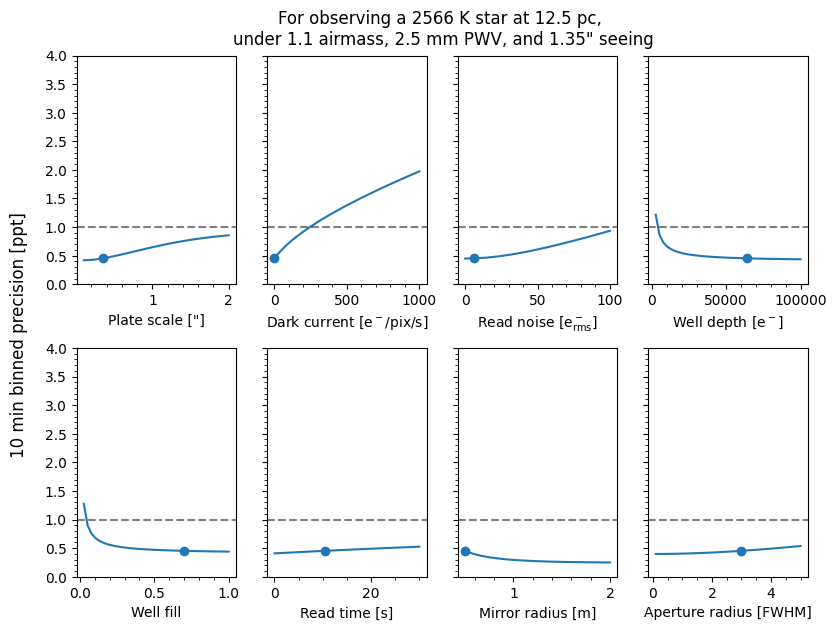

In [7]:
nice_names = {
    "plate_scale": 'Plate scale ["]',
    "N_dc": "Dark current [e$^-$/pix/s]",
    "N_rn": "Read noise [e$^-_\mathregular{rms}$]",
    "well_depth": "Well depth [e$^-$]",
    "well_fill": "Well fill",
    "read_time": "Read time [s]",
    "r0": "Mirror radius [m]",
    # "r1" : [0, 0.49, 0.14],
    "ap_rad": "Aperture radius [FWHM]",
}

fig, ax = plt.subplots(2, 4, sharey=True, figsize=(8, 6))

counter = 0
for key in ranges1:

    x = np.linspace(ranges1[key][0], ranges1[key][1], 40)
    y1 = results1[key]
    # y2 = results2[key]

    ax[int(counter / 4), counter % 4].plot(x, y1, color="tab:blue")
    # ax[int(counter/4), counter%4].plot(x, y2, color="tab:orange")
    ax[int(counter / 4), counter % 4].set(xlabel=nice_names[key], ylim=[0, 4])
    ax[int(counter / 4), counter % 4].minorticks_on()

    ax[int(counter / 4), counter % 4].plot(
        current1[key]["x"], current1[key]["bp"], marker="o", color="tab:blue"
    )
    # ax[int(counter/4), counter%4].plot(current2[key]['x'], current2[key]['bp'], marker='o', color="tab:orange")

    ax[int(counter / 4), counter % 4].axhline(1, linestyle="--", color="k", alpha=0.5)

    counter += 1


fig.text(
    -0.03,
    0.5,
    "10 min binned precision [ppt]",
    ha="center",
    va="center",
    rotation="vertical",
    fontsize=12,
)
fig.text(
    0.5,
    1.01,
    f"For observing a {Teff} K star at {distance} pc, \nunder {props_sky['airmass']} airmass, {props_sky['pwv']} mm PWV, and {props_sky['seeing']}\" seeing",
    ha="center",
    va="center",
    fontsize=12,
)

plt.tight_layout()

In [8]:
sky_ranges = {
    "pwv": [0.05, 20, props_sky["pwv"]],
    "airmass": [1, 3, props_sky["airmass"]],
    "seeing": [0.05, 3, props_sky["seeing"]],
}

results1 = {}

current1 = {}

image_precision1, binned_precision1, components1 = mphot.get_precision(
    props_instrument, props_sky, Teff, distance
)

In [9]:
for key in sky_ranges:
    print(key)
    bp1 = []
    bp2 = []
    for v in np.linspace(sky_ranges[key][0], sky_ranges[key][1], 50):
        # print(v)
        props_sky[key] = v

        image_precision1, binned_precision1, components1 = mphot.get_precision(
            props_instrument, props_sky, Teff, distance
        )

        bp1.append(binned_precision1["All"] * 1000)

    results1[key] = bp1

    # return to default value
    props_sky[key] = sky_ranges[key][2]

    # calc current val
    image_precision1, binned_precision1, components1 = mphot.get_precision(
        props_instrument, props_sky, Teff, distance
    )

    current1[key] = {}
    current1[key]["x"] = sky_ranges[key][2]
    current1[key]["bp"] = binned_precision1["All"] * 1000

pwv
airmass
seeing


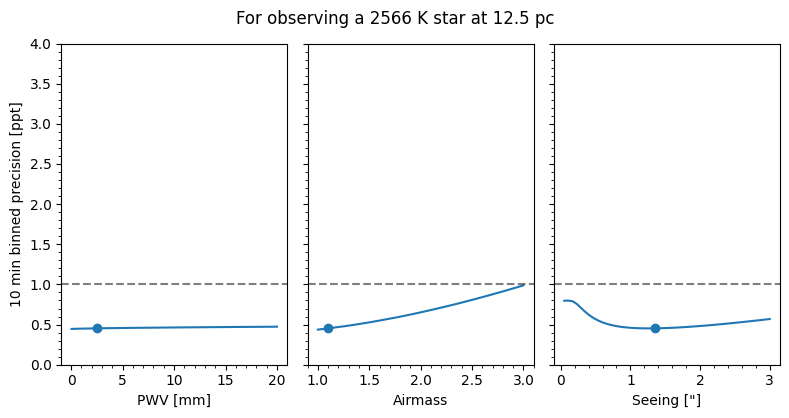

In [10]:
nice_names = {"pwv": "PWV [mm]", "airmass": "Airmass", "seeing": 'Seeing ["]'}

fig, ax = plt.subplots(1, 3, sharey=True, figsize=(8, 4))

counter = 0
for key in sky_ranges:

    x = np.linspace(sky_ranges[key][0], sky_ranges[key][1], 50)
    y1 = results1[key]
    # y2 = results2[key]

    ax[counter].plot(x, y1, color="tab:blue")
    # ax[counter].plot(x, y2, color="tab:orange")
    ax[counter].set(xlabel=nice_names[key], ylim=[0, 4])
    ax[counter].minorticks_on()

    ax[counter].plot(
        current1[key]["x"], current1[key]["bp"], marker="o", color="tab:blue"
    )
    # ax[counter].plot(current2[key]['x'], current2[key]['bp'], marker='o', color="tab:orange")

    ax[counter].axhline(1, linestyle="--", color="k", alpha=0.5)

    counter += 1


ax[0].set_ylabel("10 min binned precision [ppt]")
fig.text(
    0.5,
    1.01,
    f"For observing a {Teff} K star at {distance} pc",
    ha="center",
    va="center",
    fontsize=12,
)


plt.tight_layout()